# Processing


In [1]:
from pathlib import Path
import numpy as np

import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt

## Preprocessing
Preprocessing pipeline to "prepare" your recording prior to spike sorting.


In [2]:
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True, chunk_duration="1s")

### "Destriping" the raw traces

Neuropixels probes (and similar) have long shanks that can experience noise that appear as "stripes".
This section shows how to clean the signals and remove bad channels prior to spike sorting.

To demonstrate this, we are going to use some test datasets shared by Olivier Winter from IBL.

For more information, please refer to the IBL paper:

[Spike sorting pipeline for the International Brain Laboratory, ](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522/3)

### load data from SpikeGLX

In [3]:
import os

data_dir = "D:/SGL_DATA/test-day1- spine-bellyneuron_g1/test-day1- spine-bellyneuron_g1_imec0"
base_dir = os.path.dirname(data_dir)

spikeglx_folder = base_dir

stream_names, stream_ids = si.get_neo_streams("spikeglx", spikeglx_folder)
stream_names

['imec0.ap', 'nidq', 'imec0.lf']

In [4]:
spike_data = si.read_spikeglx(spikeglx_folder, stream_name="imec0.ap", load_sync_channel=False)
spike_data

SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 1,675,089 samples - 55.84s 
                            int16 dtype - 1.20 GiB

In [5]:
nidq_data = si.read_spikeglx(spikeglx_folder, stream_name="nidq", load_sync_channel=False)
nidq_data

SpikeGLXRecordingExtractor: 9 channels - 10.6kHz - 1 segments - 591,490 samples - 55.84s 
                            int16 dtype - 10.15 MiB

In [6]:
import matplotlib
import ipympl

matplotlib.use('module://ipympl.backend_nbagg')
backend = matplotlib.get_backend()
print(backend)  # This should print 'module://ipympl.backend_nbagg'
assert "ipympl" in backend, "ipympl backend is not set correctly"

%matplotlib widget
w = sw.plot_traces(nidq_data, backend="ipywidgets")

module://ipympl.backend_nbagg


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [7]:
%matplotlib widget
import matplotlib
print(matplotlib.get_backend())  # This should print 'module://ipympl.backend_nbagg'

w = sw.plot_traces(nidq_data, backend="ipywidgets")

module://ipympl.backend_nbagg


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [8]:
%matplotlib widget
w = sw.plot_traces(nidq_data, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Let's first take a look at the "raw" traces:

In [9]:
w = sw.plot_traces(spike_data, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

We notice there are both some horizontal and vertical "stripes", plus some "patterns".

Although Neuropixels data have a hardware highpass filter (cutoff at 150Hz), there can be come leftover content from the LFP frequency band.

So let's first highpass the data and see how it looks:

In [10]:
recording_hp = spre.highpass_filter(spike_data)

# we can visualize multiple "layers" at the same time!
recording_layers = dict(
    raw=spike_data,
    highpass=recording_hp
)
w = sw.plot_traces(recording_layers, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Now the "patterns" are mainly gone, but we can still see some vertical artefacts and some horizontal lines.

While the vertical lines can be attributed to transient external noise, the horizontal ones are mainly due to a channel either being too silent ("dead") or too "noisy".

(In addition, on the top of the probe we can observe an area of faint activity. This could indicate that the recording area is not fully in the brain, which could happen when targeting surface area.)

### Phase shift

Neuropixels probes can record from 384 channels simultaneously, but the analog-to-digital converters (ADCs) of the probe are only 32!

**This means that channels are not sampled exactly at the same time!**

Within a sampling cicle (1/30kHz = 33$\mu$s), each ADC sweeps and samples a group of channels. While this misalignment could sound small, it could affect processing steps, such as common median reference.

The delay of each channel is automatically loaded as the `inter_sample_shift` property (when reading the data with the `read_spikeglx` or `read_openephys`), which tells what is the shift between 0 (beginning of the cycle) and 1 (end of the cycle) which each channel is sampled at by the ADC.

In [11]:
print(spike_data.get_property("inter_sample_shift")[:10])

[0.         0.         0.07692308 0.07692308 0.15384615 0.15384615
 0.23076923 0.23076923 0.30769231 0.30769231]


To correct for this shift, we can use the `spre.phase_sift()` function. This function internally uses a Fourier Transform to align each channel according to its sample shift.

In [12]:
recording_ps = spre.phase_shift(recording_hp)

In [13]:
recording_layers = dict(
    highpass=recording_hp,
    phase_shift=recording_ps
)
w = sw.plot_traces(recording_layers, time_range=[0.23, 0.25], backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Detect and remove bad channels

We still observe some horizontal bands, whcih suggests the presence of bad channels.

The `spre.detect_bad_channels()` function uses several strategies (including coherence along depth, PSD energy) to label channels as:
- "good"
- "dead": the signal is too weak
- "noisy": the signal is too strong
- "out": channels outside of the brain

In [14]:
bad_channel_ids, channel_labels = spre.detect_bad_channels(recording_ps)

In [15]:
labels, counts = np.unique(channel_labels, return_counts=True)

In [16]:
for label, count in zip(labels, counts):
    print(f"Found {count} channels with label {label}")

Found 384 channels with label good


Let's remove the "bad channels" with the `remove_channels` function:

In [17]:
recording_hp_rm = recording_hp.remove_channels(bad_channel_ids)
recording_ps_rm = recording_ps.remove_channels(bad_channel_ids)

### Denoise

Now that the channels are aligned, we can use some denoisers to remove these "common mode" noisy events. 

One option is to use the `spre.common_reference` function, which removes the median of the channel at each sample.
Another option, again developed by IBL, is to apply a highpass filter, but in the "space" dimension, i.e., across depth (`spre.highpass_spatial_filter`).

Let's apply these steps with and without `phase_shift` to see the difference:

In [18]:
recording_cmr_no_ps = spre.common_reference(recording_hp_rm)
recording_cmr_ps = spre.common_reference(recording_ps_rm)
recording_hps_no_ps = spre.highpass_spatial_filter(recording_hp_rm)
recording_hps_ps = spre.highpass_spatial_filter(recording_ps_rm)

In [19]:
recording_layers = dict(
    cmr_no_ps=recording_cmr_no_ps,
    cmr_ps=recording_cmr_ps,
    hps_no_ps=recording_hps_no_ps,
    hps_ps=recording_hps_ps,
)
w = sw.plot_traces(recording_layers, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

# Kilosort 4 sorting

In [20]:
from pathlib import Path

# Define base_dir as a Path object
base_dir = Path(base_dir)  # If base_dir is a string, this converts it to a Path object

sorter_names = ['kilosort4']  # List of sorters, you can add more if needed
sortings = {}

for sorter_name in sorter_names:
    output_folder = base_dir / f'sorter_output_{sorter_name}'
    print(sorter_name, output_folder)
    
    if output_folder.exists():
        sortings[sorter_name] = si.read_sorter_folder(output_folder)
    else:
        sortings[sorter_name] = si.run_sorter(sorter_name, recording_hps_ps, output_folder, verbose=True)


kilosort4 D:\SGL_DATA\test-day1- spine-bellyneuron_g1\sorter_output_kilosort4


In [21]:
sortings

{'kilosort4': KiloSortSortingExtractor: 84 units - 1 segments - 30.0kHz}

In [22]:
import numpy as np
import pandas as pd


# outputs saved to output_folder

ops = np.load(output_folder / "sorter_output/ops.npy", allow_pickle=True).item()
camps = pd.read_csv(output_folder / "sorter_output/cluster_Amplitude.tsv", sep="\t")["Amplitude"].values
contam_pct = pd.read_csv(output_folder / "sorter_output/cluster_ContamPct.tsv", sep="\t")[
    "ContamPct"
].values
chan_map = np.load(output_folder / "sorter_output/channel_map.npy")
templates = np.load(output_folder / "sorter_output/templates.npy")
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(output_folder / "sorter_output/amplitudes.npy")
st = np.load(output_folder / "sorter_output/spike_times.npy")
clu = np.load(output_folder / "sorter_output/spike_clusters.npy")
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops["dshift"]

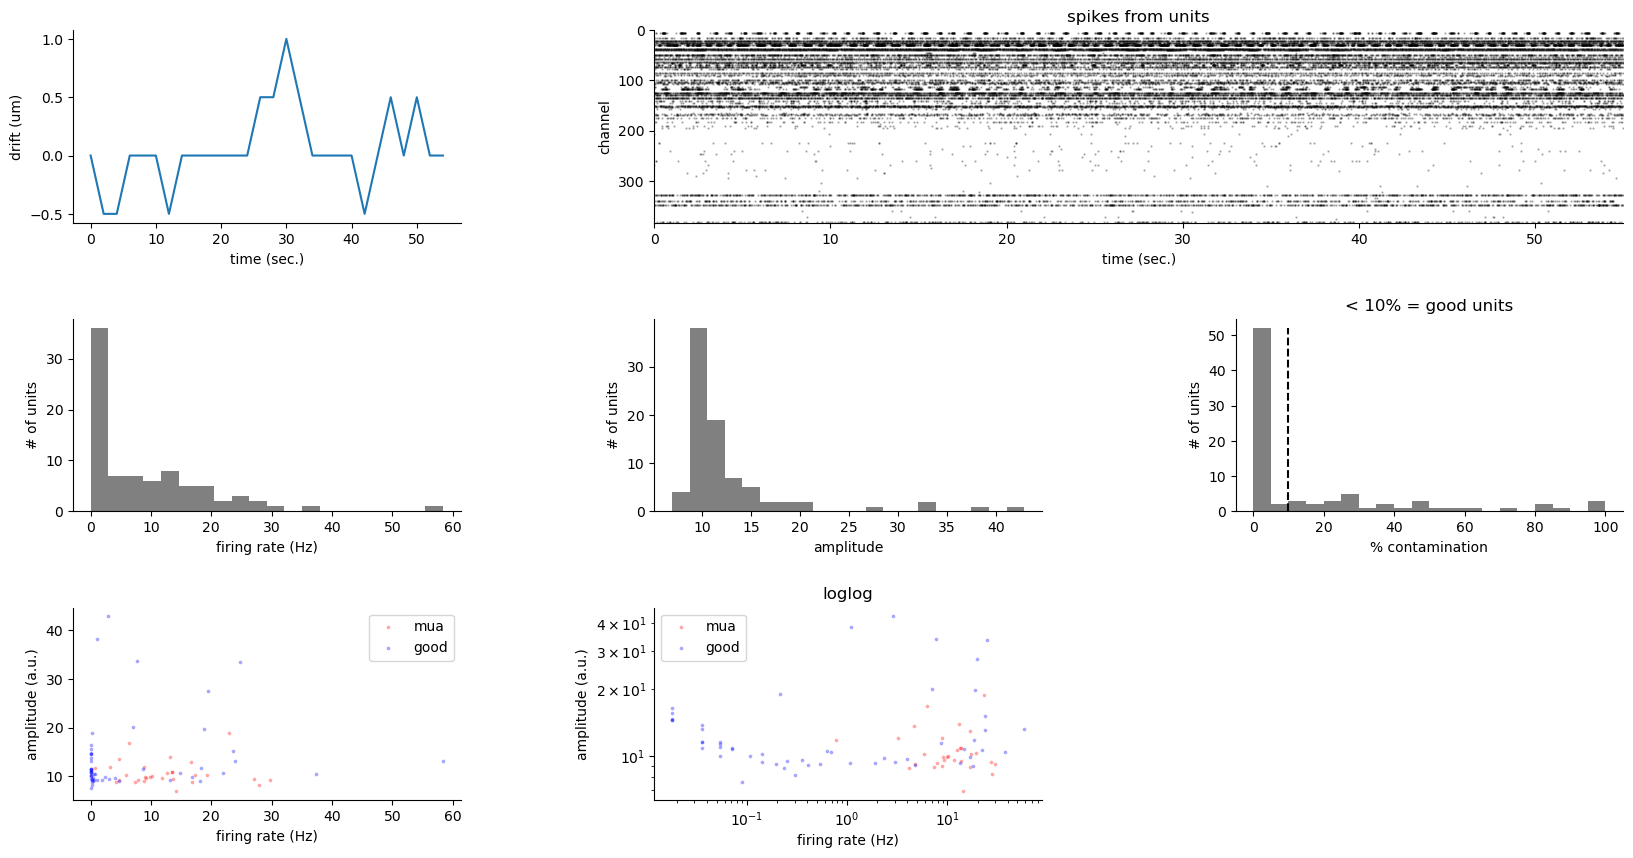

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(20,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*55)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 55])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

In [24]:
from collections import Counter
import pandas as pd

df = pd.DataFrame(
    {"spike_times": st[t0:t1] / 30000.0, "channel": chan_best[clu[t0:t1]]}
)

s = df.sort_values("channel")

c = Counter(s["channel"])

sorted_count = sorted(c.items(), key=lambda i: i[0])

truncated_channel = []
for i in range(len(sorted_count)):
    temp_list = [i] * sorted_count[i][1]
    truncated_channel += temp_list

In [25]:
len(chan_best)

84

In [26]:
assert len(truncated_channel) == len(s)
s["truncated_channel"] = truncated_channel

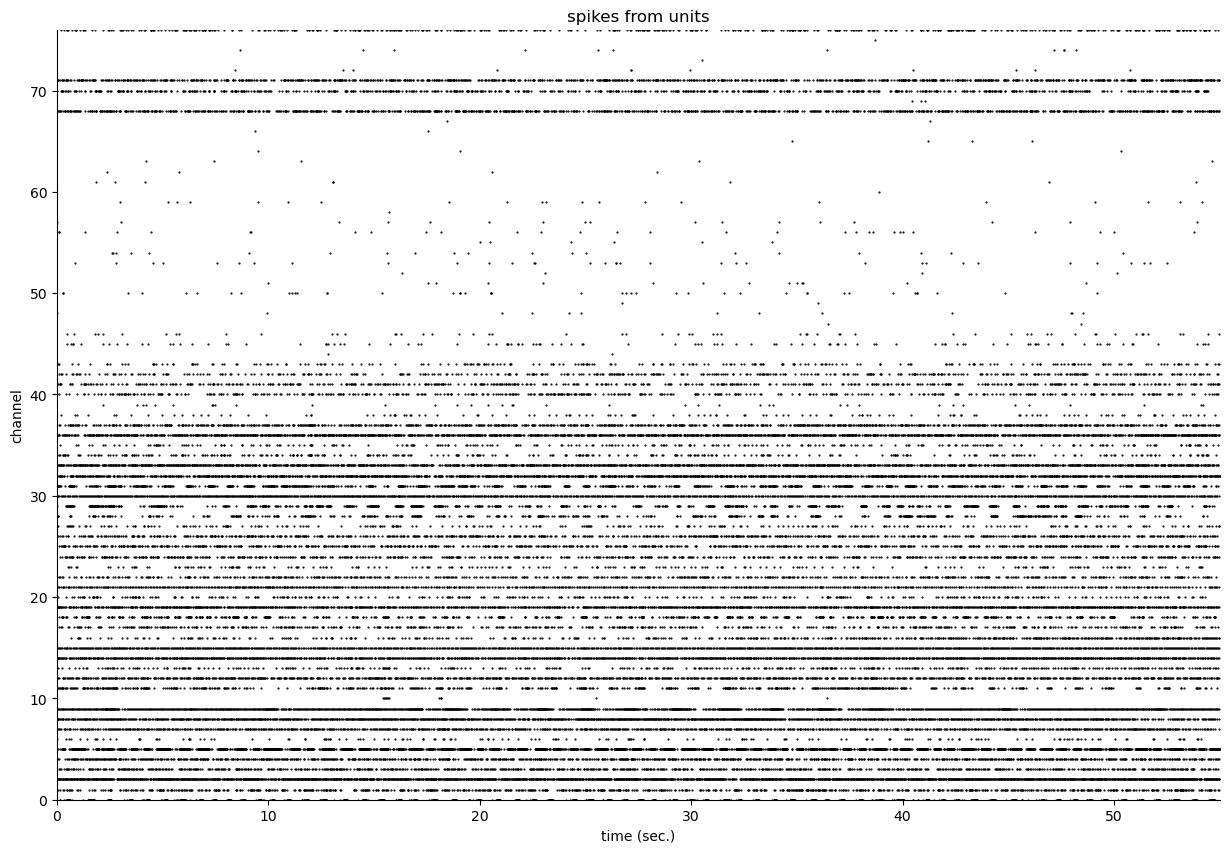

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
t0 = 0
final_time = 55
t1 = np.nonzero(st > ops["fs"] * final_time)[0][0]
# ax.scatter(st[t0:t1] / 30000.0, chan_best[clu[t0:t1]], s=0.5, color="k", alpha=0.25)
ax.scatter(s["spike_times"], s["truncated_channel"], s=0.3, color="k", alpha=1)
ax.set_xlim([0, s["spike_times"].max()])
ax.set_ylim([s["truncated_channel"].max(), 0])
ax.set_ylim([0, s["truncated_channel"].max()])
ax.set_xlabel("time (sec.)")
ax.set_ylabel("channel")
ax.set_title("spikes from units")

plt.savefig(f"{base_dir}_raster.svg", dpi=300, transparent=True)

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


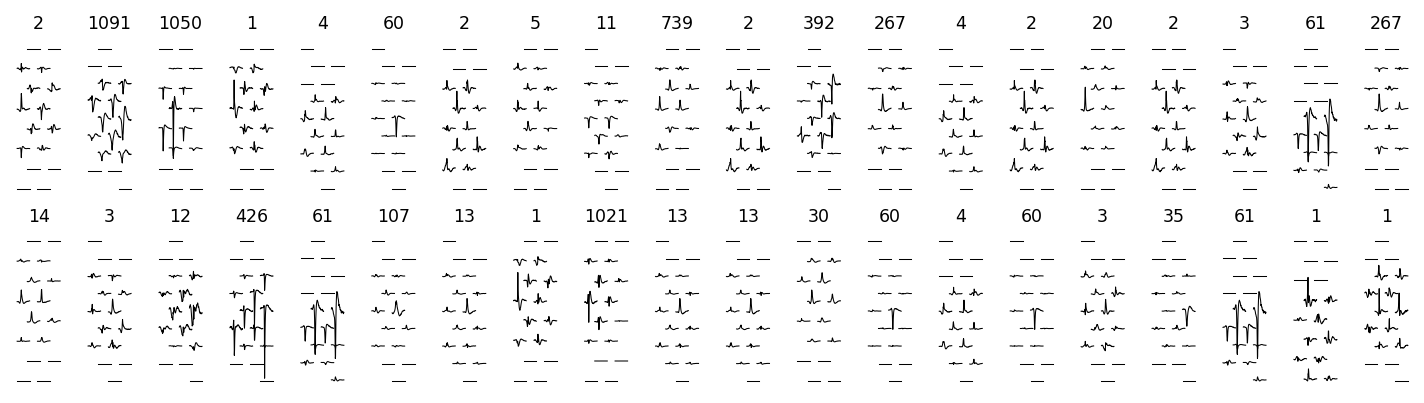

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


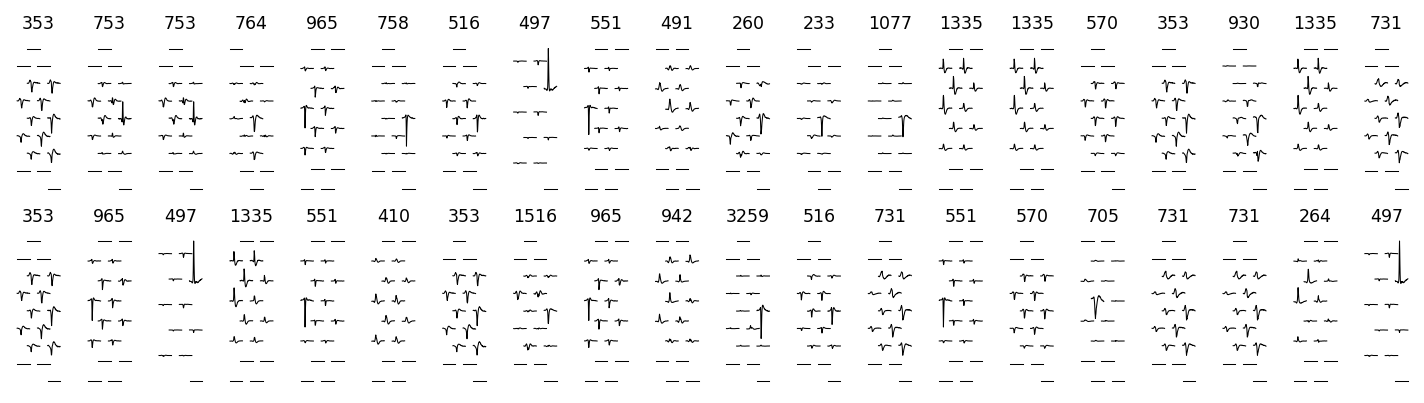

In [28]:
probe = ops["probe"]
# x and y position of probe sites
xc, yc = probe["xc"], probe["yc"]
nc = 16  # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ["good", "mua"]
for j in range(2):
    print(f"~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("title = number of spikes from each unit")
    units = good_units if j == 0 else mua_units
    fig = plt.figure(figsize=(12, 3), dpi=150)
    grid = gridspec.GridSpec(2, 20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu == wi).sum()

        ax = fig.add_subplot(grid[k // 20, k % 20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb - nc // 2)
        ic1 = min(n_chan, cb + nc // 2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi, yi) in enumerate(zip(x0, y0)):
            t = np.arange(-wv.shape[0] // 2, wv.shape[0] // 2, 1, "float32")
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:, ii] * amp, lw=0.5, color="k")

        ax.set_title(f"{nsp}", fontsize="small")
        ax.axis("off")
    plt.show()

## Postprocessing

In [29]:
analyzer_in_memory = si.create_sorting_analyzer(sorting=sortings['kilosort4'], recording=recording_hps_ps)


estimate_sparsity:   0%|          | 0/56 [00:00<?, ?it/s]

In [35]:
analyzer = analyzer_in_memory.save_as(format="binary_folder", folder=base_dir/"my_sorting_analyzer1")

ValueError: Folder already exists D:\SGL_DATA\test-day1- spine-bellyneuron_g1\my_sorting_analyzer1

In [36]:
print(analyzer)
print(analyzer_in_memory)

SortingAnalyzer: 384 channels - 84 units - 1 segments - binary_folder - sparse - has recording
Loaded 0 extensions: 
SortingAnalyzer: 384 channels - 84 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions: 


In [37]:
required_extensions = [
    "random_spikes",
    "waveforms",
    "templates",
    "noise_levels",
    "unit_locations",
    "template_similarity",
    "spike_amplitudes",
    "correlograms"
]
analyzer.compute(required_extensions)
analyzer

compute_waveforms:   0%|          | 0/56 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/56 [00:00<?, ?it/s]

SortingAnalyzer: 384 channels - 84 units - 1 segments - binary_folder - sparse - has recording
Loaded 8 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, template_similarity, correlograms, spike_amplitudes

In [38]:
num_spikes = sortings['kilosort4'].count_num_spikes_per_unit()
unit_amplitudes = si.get_template_extremum_amplitude(analyzer)

analyzer.sorting.set_property("num_spikes", list(num_spikes.values()))
analyzer.sorting.set_property("amplitude", list(unit_amplitudes.values()))

In [39]:
analyzer_saved = analyzer.save_as(
    folder=base_dir / "analyzer_for_visualization",
)

In [40]:
# ! pip install --upgrade sortingview
# ! pip install jupyter extension

In [41]:
w = sw.plot_sorting_summary(
    analyzer,
    unit_table_properties=["num_spikes", "amplitude"], 
    curation=True, 
    label_choices=["noise", "MUA", "SUA"],
    backend="spikeinterface_gui"
    # backend="sortingview"
)

In [42]:
# ! pip install ephyviewer

In [43]:
# %gui qt
# sw.plot_traces(recording_hps_ps, backend="ephyviewer")

In [44]:
analyzer_saved.compute("principal_components", n_components=3, mode="by_channel_global")
analyzer_saved.compute("quality_metrics", metric_names=["snr"])
analyzer_saved

Fitting PCA:   0%|          | 0/84 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/84 [00:00<?, ?it/s]

c:\Users\Labtech\anaconda3\envs\si_tutorial\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:230: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise


SortingAnalyzer: 384 channels - 84 units - 1 segments - memory - sparse - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, template_similarity, correlograms, spike_amplitudes, principal_components, quality_metrics

In [45]:
%gui qt
sw.plot_sorting_summary(analyzer_saved, backend="spikeinterface_gui")

In [46]:
extensions_to_compute = {
    #'principal_components': {
    #    'n_components': 4
    #},
    'spike_amplitudes': {},
    'amplitude_scalings': {},
    'spike_locations': {},
    'template_metrics': {},
    'template_similarity': {},
    'unit_locations': {
        'method': 'monopolar_triangulation'
    },
}

analyzer.compute(extensions_to_compute)

Compute : spike_amplitudes + amplitude_scalings + spike_locations:   0%|          | 0/56 [00:00<?, ?it/s]

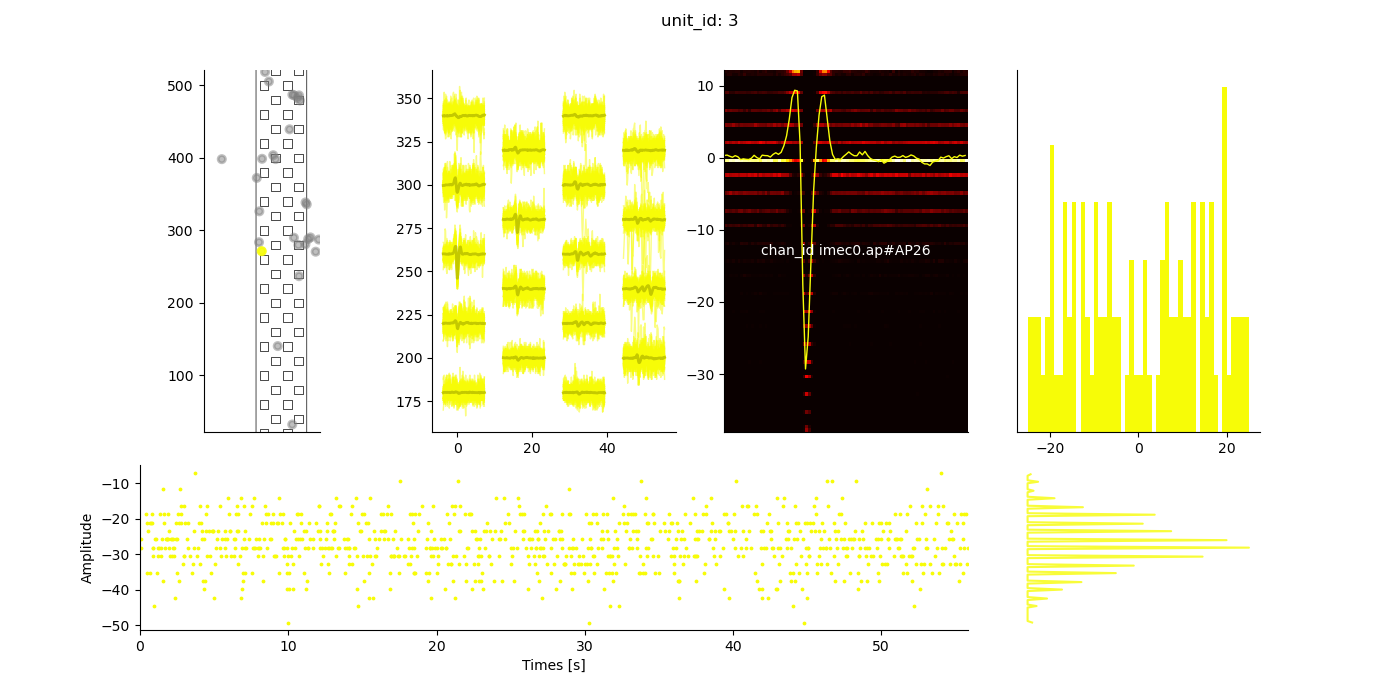

In [54]:
# activate the matplotlib widget
import matplotlib.pyplot
%matplotlib widget

sw.plot_unit_summary(analyzer, unit_id=3, figsize=(14,7))

In [48]:
# sw.plot_unit_locations(analyzer, backend="ipywidgets")

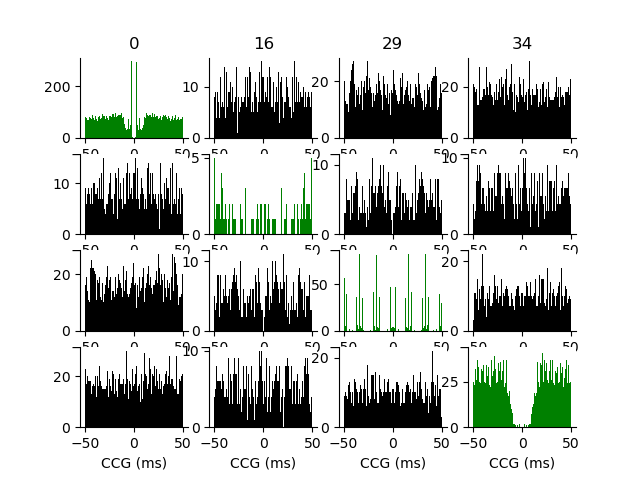

In [49]:
sw.plot_crosscorrelograms(analyzer.sorting,  unit_ids=[0,16,29,34])

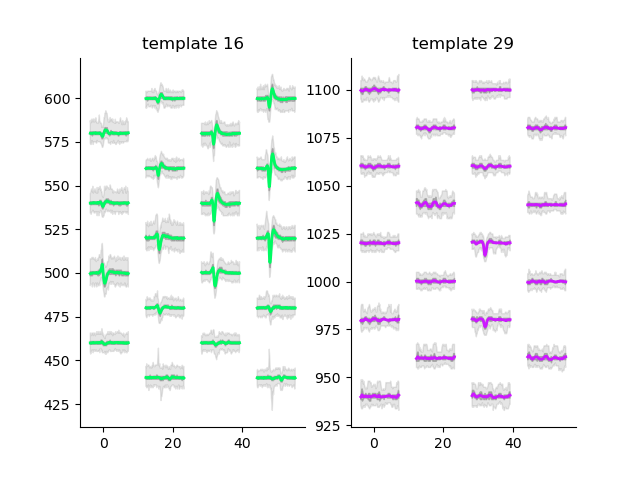

In [50]:
sw.plot_unit_templates(analyzer, unit_ids=[16,29])

In [51]:
sw.plot_amplitudes(analyzer, plot_histograms=True, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

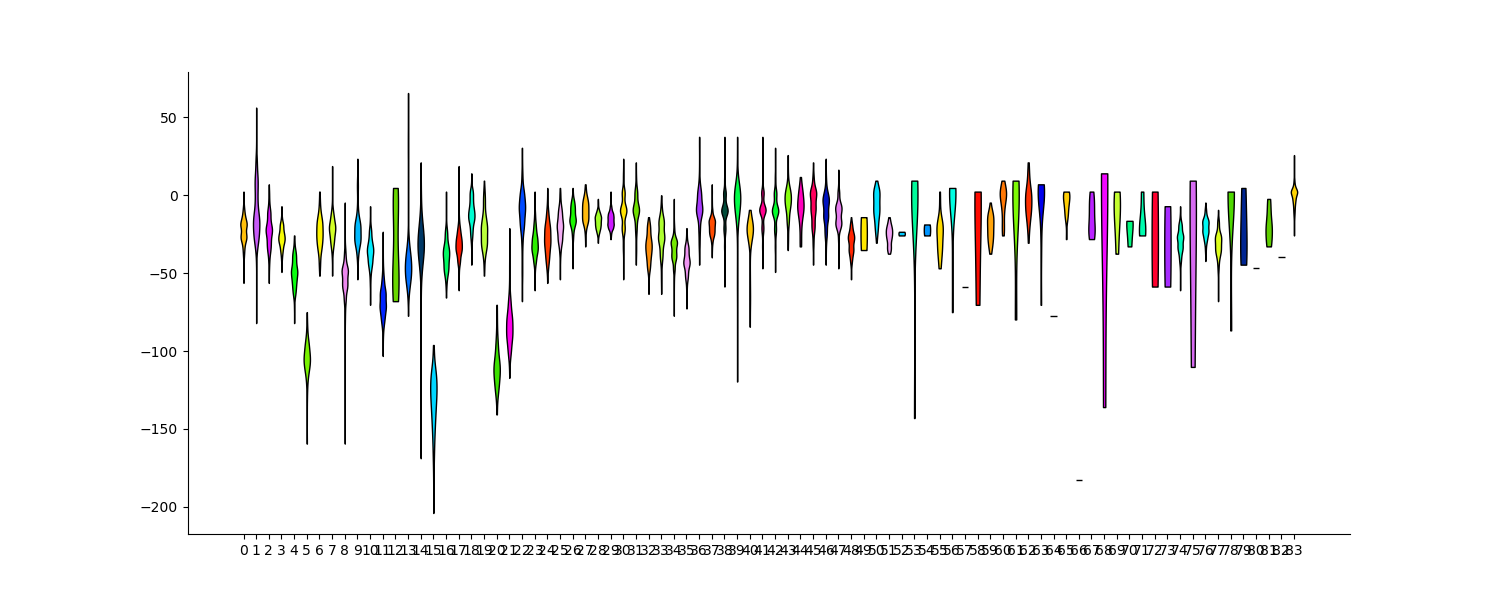

In [52]:
sw.plot_all_amplitudes_distributions(analyzer, figsize=(15,6))

In [ ]:
# events_artifacts = np.load(events_path)
# print(events_artifacts)
# print(events_artifacts.dtype)

In [ ]:
# first_event_time = events_artifacts["time"][0]
# time_range = [first_event_time - 0.02, first_event_time + 0.02]

In [ ]:
# recording_hp_artifacts = spre.highpass_filter(recording_artifacts)
# recording_ps_artifacts = spre.phase_shift(recording_hp_artifacts)

**NOTE:** since both filtering and phase-shift are linear operations, the order doesn't matter!

In [ ]:
# data_chunk = si.get_random_data_chunks(
#     recording_ps_artifacts,
#     num_chunks_per_segment=1,
#     chunk_size=30000,
#     seed=0
# )

# fig, ax = plt.subplots(figsize=(10, 7))
# for tr in data_chunk.T:
#     p, f = ax.psd(tr, Fs=recording_ps_artifacts.sampling_frequency, color="b")

In [ ]:
# recording_artifacts_notch = spre.notch_filter(recording_ps_artifacts, freq=10000, q=10)